# Kaggle Toxic Comment Classification

* Identify and classify toxic online comments
* Ref: https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84
* Ref: https://zhuanlan.zhihu.com/p/34722385
* Ref: https://www.jianshu.com/p/e5adb235399e
* Ref: http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* Ref: http://anie.me/On-Torchtext/
* Ref: https://github.com/bentrevett/pytorch-sentiment-analysis

In [25]:
import os
import subprocess

classpath = os.environ['CLASSPATH']
hadoop_path = os.path.join(os.environ['HADOOP_PREFIX'], 'bin', 'hadoop')
hadoop_classpath = subprocess.check_output([hadoop_path, 'classpath', '--glob']).decode()
os.environ['CLASSPATH'] = classpath + os.pathsep + hadoop_classpath

In [26]:
import random, re, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as torch_F
import tensorflow as tf

from torchtext import data
from torchtext.vocab import Vectors

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

# fix random state
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# CuDNN reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%matplotlib inline

In [27]:
spark = SparkSession.builder \
        .appName('Kaggle_Toxic_Comment_Classification') \
        .enableHiveSupport() \
        .getOrCreate()
        
spark

In [28]:
# using GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Part I: Create Dataset and Dataloader

### 1. Move csv files to temp locations

In [29]:
# move file to temp location
path = 'hdfs://default/user/jzhao01/pytorch-examples/data/toxic-comment/train.csv'
with tf.gfile.GFile(path, 'rb') as f:
    gfile_model = f.read()
    
with open('train.csv', 'wb') as f:
    f.write(gfile_model)
    
path = 'hdfs://default/user/jzhao01/pytorch-examples/data/toxic-comment/test.csv'
with tf.gfile.GFile(path, 'rb') as f:
    gfile_model = f.read()
    
with open('test.csv', 'wb') as f:
    f.write(gfile_model)

### 2. Define custom tokenizer

In [30]:
# define custom tokenizer
# ref: https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84
# ref: https://zhuanlan.zhihu.com/p/34722385

def tokenizer(comment: str):
    comment = str(comment).lower()
    comment = re.sub(r"'m", " am", comment)
    comment = re.sub(r"n't", " not", comment)
    comment = re.sub(r"'ll", ' will', comment)
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;.#$%&;@%!,?']", " ", comment)
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", " ", comment)
    comment = re.sub(r"\,+", " ", comment)
    comment = re.sub(r"\?+", " ", comment)

    tokens = comment.split()
    
    return tokens

### 3. Define data fields and create train, val, and test data

In [31]:
# define data fields
TEXT = data.Field(sequential=True, lower=True, tokenize=tokenizer, batch_first=True, 
                  pad_first=True, is_target=False)

LABELS = data.Field(sequential=False, use_vocab=False, batch_first=True, is_target=True)

In [32]:
# create dataset
fields = [('id', None), ('comment_text', TEXT), ('toxic', LABELS), ('severe_toxic', LABELS), 
          ('obscene', LABELS), ('threat', LABELS), ('insult', LABELS), ('identity_hate', LABELS)] 

train = data.TabularDataset(path='./train.csv', format='CSV', fields=fields, skip_header=True)

train, val = train.split(split_ratio=0.8)

test = data.TabularDataset(path='./test.csv', format='CSV', fields=fields, skip_header=True)

In [33]:
# use pre-trained embeddings
vectors = Vectors(name='./glove.6B.100d.txt')

In [34]:
# build Vocab
TEXT.build_vocab(train, val, test, vectors=vectors)

In [35]:
# build iterator
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_sizes=(128, 128), repeat=False, 
                                                  sort_key=lambda x: len(x.comment_text), 
                                                  shuffle=True, sort_within_batch=False)

test_iter = data.Iterator(test, batch_size=1, train=False, repeat=False, shuffle=False, sort=False)

In [36]:
# build custom iterator wrapper
class BatchWrapper(object):
    def __init__(self, data_iter, x_var, y_vars):
        self.data_iter = data_iter
        self.x_var = x_var
        self.y_vars = y_vars
        
    def __iter__(self):
        for batch in self.data_iter:
            x = getattr(batch, self.x_var)
            y_list = [getattr(batch, y_var).unsqueeze(1) for y_var in self.y_vars]
            y = torch.cat(y_list, dim=1).float()
            
            yield (x, y)
            
    def __len__(self):
        return len(self.data_iter)
    
# wrap iterators
x_var = 'comment_text'
y_vars = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# create dataloader
train_loader = BatchWrapper(train_iter, x_var, y_vars)
val_loader = BatchWrapper(val_iter, x_var, y_vars)
test_loader = BatchWrapper(test_iter, x_var, y_vars)

# Part II: Modeling

### 1. Define bidirectional LSTM model

In [37]:
# define bidirectional LSTM model
class MyLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, fc_size, dropout=0.5):
        super(MyLSTM, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size * 2, fc_size)
        self.bn = nn.BatchNorm1d(fc_size)
        self.dropout = nn.Dropout(p=dropout)
        
        self.fc2 = nn.Linear(fc_size, 6)
        
    def forward(self, x):
        # word embedding
        embeds = self.embedding(x)
        output, _ = self.lstm(embeds)
        batch, seq_len, _ = output.shape
        output = output.reshape(batch, seq_len, 2, -1)
        
        forward_output = output[:, -1, 0, :].view(batch, -1)
        backward_output = output[:, 0, 1, :].view(batch, -1)
        concat = torch.cat([forward_output, backward_output], dim=1)
        
        # dropout and fully-connected layer
        x = self.dropout(concat)
        x = torch_F.relu(self.fc1(x))
        x = self.bn(x)
        x = self.dropout(x)
        
        output = self.fc2(x)
        
        return output

### 2. Build the model

In [38]:
# determine vector size
vectors = TEXT.vocab.vectors
vectors.shape

torch.Size([280602, 100])

In [39]:
# define 1 layer LSTM
model = MyLSTM(num_embeddings=len(vectors), 
               embedding_dim=100, 
               hidden_size=32, 
               fc_size=24,
               dropout=0.5)

# move device to GPU
model = model.to(device)

model

MyLSTM(
  (embedding): Embedding(280602, 100)
  (lstm): LSTM(100, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=24, bias=True)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=24, out_features=6, bias=True)
)

In [40]:
# use pretrained embedding
model.embedding.weight.data = vectors.to(device)
model.embedding.weight.requires_grad = False

In [41]:
# define loss and optimizer
criterion = nn.BCEWithLogitsLoss(reduction='sum')

params = [param for param in model.parameters() if param.requires_grad is True]
optimizer = optim.Adam(params=params, lr=0.001)

In [42]:
# train neural network
num_epochs = 100
train_loss_list = []
val_loss_list = []

# keep recording the best model
best_epoch = None
train_best_loss = float('inf')
val_best_loss = float('inf')

for i in range(num_epochs):
    t0 = time.time()
    train_loss = 0
    train_cnt = 0
    
    # training steps
    model.train()
    for batch_x, batch_y in train_loader:
        # move to GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_cnt += len(batch_x)
        
    # validation steps
    val_loss = 0
    val_cnt = 0
    
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # move to GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)    
    
            output = model(batch_x)
            loss = criterion(output, batch_y)
            
            val_loss += loss.item()
            val_cnt += len(batch_x)
       
    # help information
    train_epoch_loss = train_loss / train_cnt
    val_epoch_loss = val_loss / val_cnt
    
    train_loss_list.append(train_epoch_loss)
    val_loss_list.append(val_epoch_loss)
    
    elapsed_time = time.time() - t0
    string_prefix = 'Epoch {:3} ===>  train_loss:{:8.5f}  val_loss:{:8.5f}  time:{:5.0f}s'
    print(string_prefix.format(i + 1, train_epoch_loss, val_epoch_loss, elapsed_time))
    
    # keep recording the best model
    if val_epoch_loss < val_best_loss:
        best_epoch = i + 1
        train_best_loss = train_epoch_loss
        val_best_loss = val_epoch_loss
        
        # save the bestmodel
        torch.save(model.state_dict(), 'toxic_model.pt')
        with open('toxic_model.pt', 'rb') as f:
            f_content = f.read()

        path = 'hdfs://default/user/jzhao01/pytorch-examples/models/toxic_model.pt'
        with tf.io.gfile.GFile(path, 'wb') as f:
            f.write(f_content)

# get the best model information
print('-' * 80)
print('Best Model')
string_prefix = 'Epoch {:3} ===>  train_loss:{:8.5f}  val_loss:{:8.5f}'
print(string_prefix.format(best_epoch, train_best_loss, val_best_loss))
print('-' * 80)

Epoch   1 ===>  train_loss: 1.41647  val_loss: 0.43500  time:   59s
Epoch   2 ===>  train_loss: 0.48147  val_loss: 0.35985  time:   54s
Epoch   3 ===>  train_loss: 0.42390  val_loss: 0.35269  time:   54s
Epoch   4 ===>  train_loss: 0.39580  val_loss: 0.35674  time:   54s
Epoch   5 ===>  train_loss: 0.38603  val_loss: 0.32332  time:   54s
Epoch   6 ===>  train_loss: 0.36918  val_loss: 0.34209  time:   55s
Epoch   7 ===>  train_loss: 0.36013  val_loss: 0.32073  time:   55s
Epoch   8 ===>  train_loss: 0.36014  val_loss: 0.31327  time:   55s
Epoch   9 ===>  train_loss: 0.34566  val_loss: 0.32610  time:   55s
Epoch  10 ===>  train_loss: 0.34275  val_loss: 0.36484  time:   54s
Epoch  11 ===>  train_loss: 0.33378  val_loss: 0.32495  time:   54s
Epoch  12 ===>  train_loss: 0.32853  val_loss: 0.31740  time:   56s
Epoch  13 ===>  train_loss: 0.32224  val_loss: 0.31752  time:   55s
Epoch  14 ===>  train_loss: 0.33635  val_loss: 0.31122  time:   55s
Epoch  15 ===>  train_loss: 0.31826  val_loss: 0

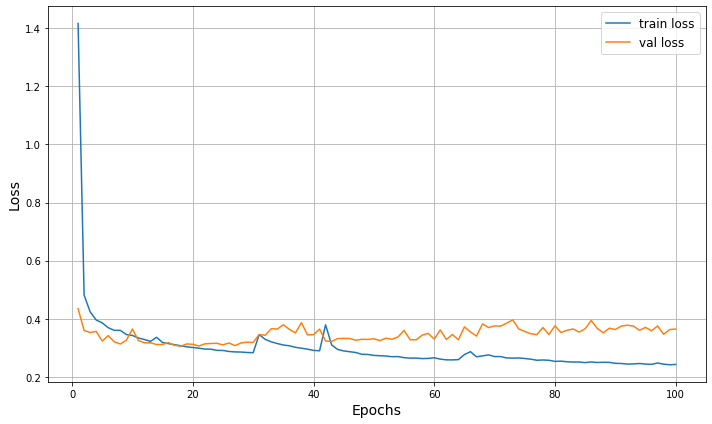

In [43]:
# visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='train loss')
ax.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='val loss')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

### 3. Make predictions

In [44]:
# load trained model
path = 'hdfs://default/user/jzhao01/pytorch-examples/models/toxic_model.pt'
with tf.gfile.GFile(path, 'rb') as f:
    gfile_model = f.read()
    
with open('tmp_model.pt', 'wb') as f:
    f.write(gfile_model)
    
# load model state_dict
state_dict = torch.load('tmp_model.pt')

# define 1 layer LSTM
model = MyLSTM(num_embeddings=len(vectors), 
               embedding_dim=100, 
               hidden_size=32, 
               fc_size=24,
               dropout=0.5)

# move model to GPU
model = model.to(device)
model.load_state_dict(state_dict)

# change to evaluation 
model.eval()

model

MyLSTM(
  (embedding): Embedding(280602, 100)
  (lstm): LSTM(100, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=24, bias=True)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=24, out_features=6, bias=True)
)

In [45]:
# make predictions
test_label = []
test_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        # corner case: no sentence
        if batch_x.shape[1] == 0:
            test_pred.append(np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
            test_label.append(batch_y.detach().squeeze().numpy())
            continue
            
        # move to GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)    
            
        output = model(batch_x)
        prediction = torch.sigmoid(output).to('cpu').detach().squeeze().numpy()
        
        test_pred.append(prediction)
        test_label.append(batch_y.to('cpu').detach().squeeze().numpy())
            
test_pred = np.array(test_pred)
test_label = np.array(test_label, dtype=int)

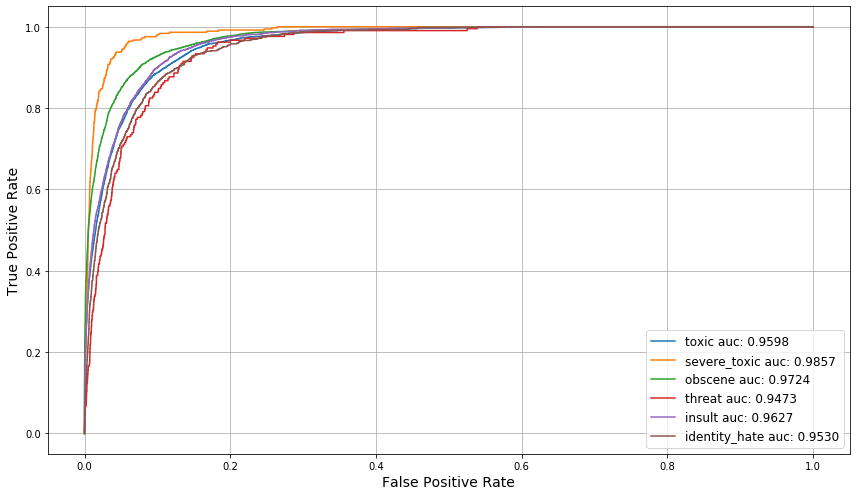

In [46]:
# calculate AUC
names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fpr_list = []
tpr_list = []
auc_list = []

for i in range(6):
    y_true = test_label[:, i]
    y_score = test_pred[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)

# visualization
fig, ax = plt.subplots(figsize=(12, 7))
for i in range(6):
    fpr, tpr, auc = fpr_list[i], tpr_list[i], auc_list[i]
    label = '{} auc: {:5.4f}'.format(names[i], auc)
    ax.plot(fpr, tpr, label=label)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

In [47]:
spark.stop()